In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

import pandas as pd
import yfinance as yf
from statsmodels.stats.stattools import durbin_watson, jarque_bera
import scipy.optimize as sco

In [2]:
tickers = ['AAPL', 'BAC', 'INTC', 'GME', 'BA', 'BABA', 'UA', 'KO', 'NVDA', 'META']

In [3]:
data = yf.download(tickers, start = '2023-01-01', end = '2025-01-01', group_by = 'ticker', threads = True)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  10 of 10 completed


In [4]:
data.stack()

C:\Users\dfdop\AppData\Local\Temp\ipykernel_12540\2489631911.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  data.stack()


Ticker                     BABA           UA          NVDA            KO  \
Date       Price                                                           
2023-01-03 Close   8.882938e+01        8.890  1.430328e+01  5.878238e+01   
           High    9.121476e+01        9.195  1.498372e+01  5.935199e+01   
           Low     8.764150e+01        8.870  1.408446e+01  5.806335e+01   
           Open    8.798917e+01        9.050  1.483884e+01  5.935199e+01   
           Volume  2.789100e+07  3266236.000  4.012770e+08  1.218050e+07   
...                         ...          ...           ...           ...   
2024-12-31 Close   8.479000e+01        7.460  1.342776e+02  6.180391e+01   
           High    8.535000e+01        7.510  1.380573e+02  6.197267e+01   
           Low     8.442000e+01        7.350  1.338177e+02  6.134728e+01   
           Open    8.442000e+01        7.430  1.380173e+02  6.156567e+01   
           Volume  7.415000e+06  2716602.000  1.556592e+08  9.256700e+06   

Ticker                      BAC            BA          INTC           GME  \
Date       Price                                                            
2023-01-03 Close   3.149291e+01  1.953900e+02  2.577514e+01  1.720000e+01   
           High    3.203800e+01  1.971800e+02  2.610300e+01  1.926000e+01   
           Low     3.121097e+01  1.924000e+02  2.542800e+01  1.709000e+01   
           Open    3.122977e+01  1.929500e+02  2.608371e+01  1.864000e+01   
           Volume  3.522150e+07  8.624600e+06  3.130800e+07  5.135200e+06   
...                         ...           ...           ...           ...   
2024-12-31 Close   4.367439e+01  1.770000e+02  2.005000e+01  3.134000e+01   
           High    4.395263e+01  1.793500e+02  2.040000e+01  3.244000e+01   
           Low     4.343589e+01  1.758200e+02  1.988000e+01  3.110000e+01   
           Open    4.376382e+01  1.775400e+02  1.999000e+01  3.206000e+01   
           Volume  1.611040e+07  9.748600e+06  4.984670e+07  7.395300e+06   

Ticker                     META          AAPL  
Date       Price                               
2023-01-03 Close   1.241549e+02  1.236325e+02  
           High    1.257772e+02  1.293955e+02  
           Low     1.217064e+02  1.227429e+02  
           Open    1.222439e+02  1.287826e+02  
           Volume  3.552850e+07  1.121175e+08  
...                         ...           ...  
2024-12-31 Close   5.849896e+02  2.501450e+02  
           High    5.934420e+02  2.530018e+02  
           Low     5.833310e+02  2.491561e+02  
           Open    5.917436e+02  2.521628e+02  
           Volume  6.019500e+06  3.948070e+07  

[2510 rows x 10 columns]

<Axes: xlabel='Date'>

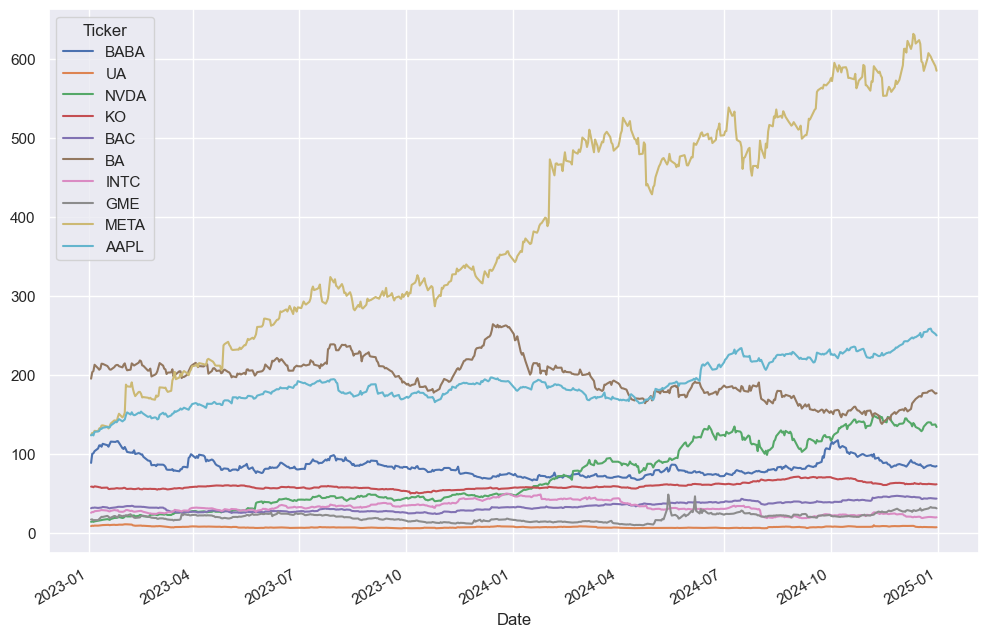

In [5]:
close_prices = data.xs('Close', axis = 1, level = 1)
close_prices.plot(kind = 'line', figsize = (12, 8))

<Axes: xlabel='Date'>

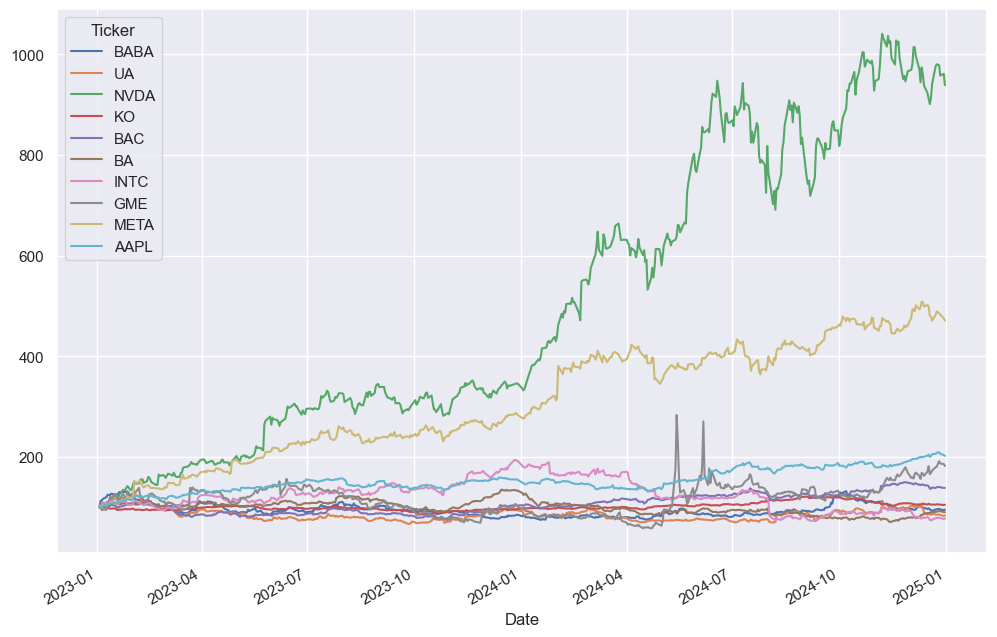

In [6]:
normalize_prices = close_prices.div(close_prices.iloc[0]).mul(100)
normalize_prices.plot(kind = 'line', figsize = (12, 8))

In [7]:
simple_retunrs = close_prices.pct_change().dropna()

<Axes: xlabel='Date'>

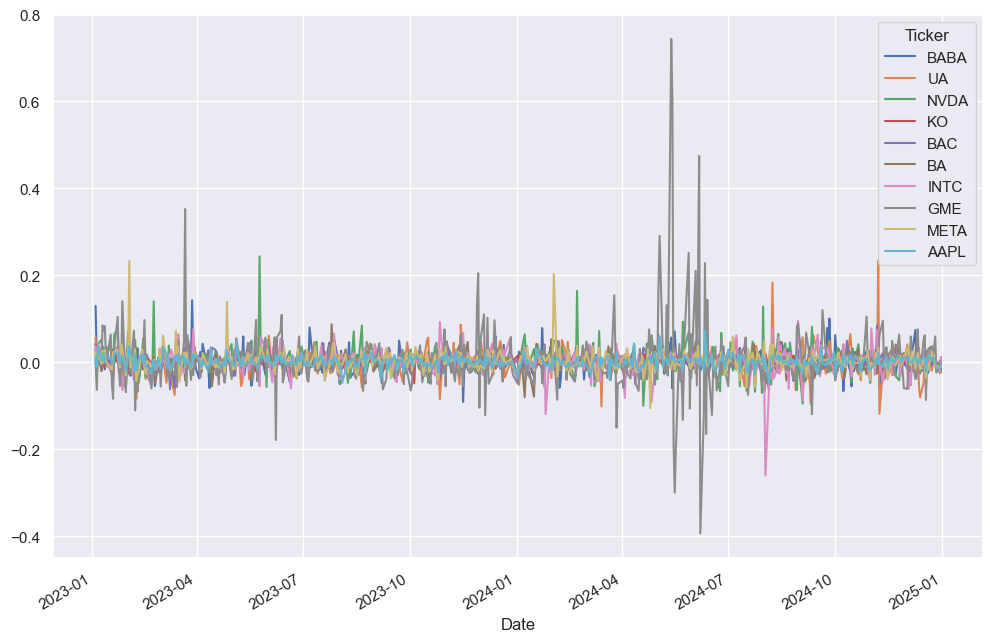

In [8]:
simple_retunrs.plot(kind = 'line', figsize = (12, 8))

In [9]:
daily_returns = simple_retunrs.mean()
daily_risk = simple_retunrs.std()

In [10]:
yearly_returns = daily_returns.apply(lambda x : (1 + x)**252 - 1)
yearly_risk = daily_risk.apply(lambda x : x * np.sqrt(252))

In [11]:
return_risk = pd.concat([yearly_returns, yearly_risk], axis=1)
return_risk.columns = ['yearly_returns', 'yearly_risk']

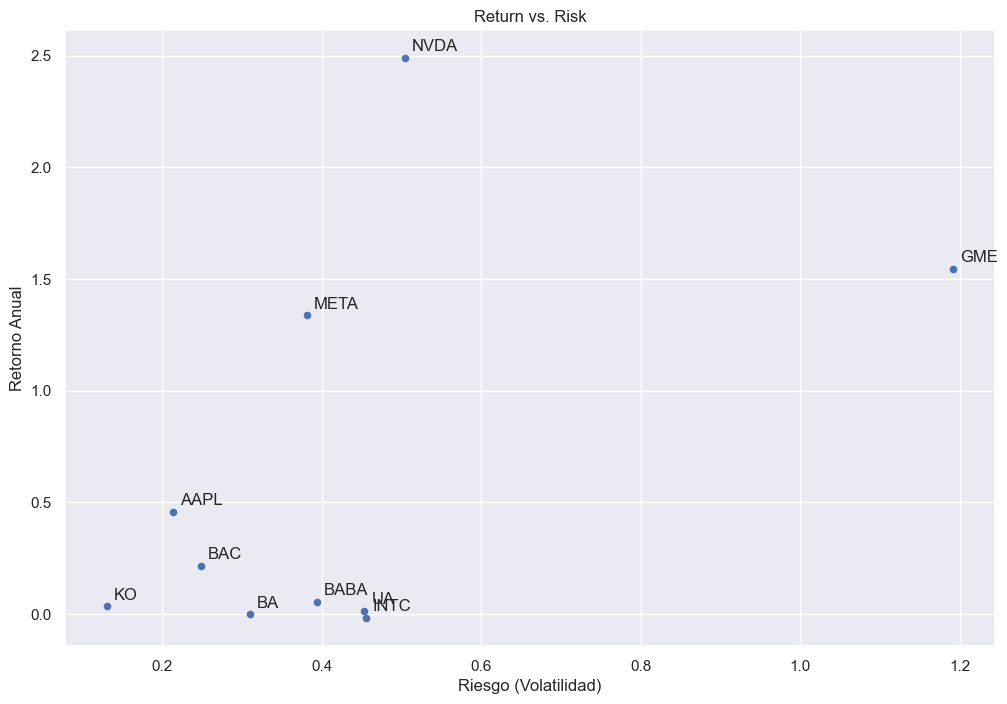

In [12]:
ax = return_risk.plot(
    kind = 'scatter',
    x = 'yearly_risk',
    y = 'yearly_returns',
    figsize = (12, 8),
    title = 'Return vs. Risk'
)

for ticker, row in return_risk.iterrows():
    ax.annotate(
        ticker,
        (row['yearly_risk'], row['yearly_returns']),
        xytext = (5, 5),
        textcoords = 'offset points'
    )
plt.xlabel('Riesgo (Volatilidad)')
plt.ylabel('Retorno Anual')
plt.show()

Calculando la frontera eficiente por medio de simulacion

In [13]:
cov_matrix = simple_retunrs.cov().to_numpy()
exp_returns = yearly_returns.to_numpy()

n_portfolios = 2000000
results = np.zeros((3, n_portfolios))
weights_record = []

for i in range(n_portfolios):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)
    weights_record.append(weights)

    port_return = np.dot(weights, exp_returns)
    port_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))* 252)

    results[0, i] = port_std
    results[1, i] = port_return
    # Compute Sharp Ratio with a free risk iquals zero
    results[2, i] = port_return / port_std


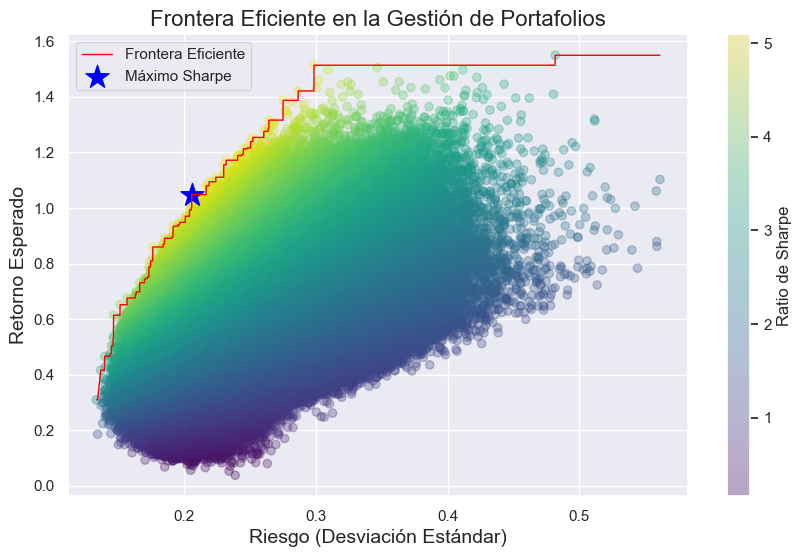

In [14]:
max_sharpe_idx = np.argmax(results[2])
max_sharpe_std = results[0, max_sharpe_idx]
max_sharpe_ret = results[1, max_sharpe_idx]
max_sharpe_weights = weights_record[max_sharpe_idx]

# Ordenar portafolios por riesgo para calcular la frontera eficiente
sorted_indices = np.argsort(results[0])
sorted_risks = results[0, sorted_indices]
sorted_returns = results[1, sorted_indices]

# Calcular el máximo acumulado de retornos, que aproxima la frontera eficiente
efficient_returns = np.maximum.accumulate(sorted_returns)

# Crear el gráfico
plt.figure(figsize=(10, 6))
sc = plt.scatter(results[0], results[1], c=results[2], cmap='viridis', alpha=0.3)
plt.plot(sorted_risks, efficient_returns, color='red', linewidth=1, label='Frontera Eficiente')
plt.scatter(max_sharpe_std, max_sharpe_ret, color='blue', marker='*', s=300, label='Máximo Sharpe')
plt.title('Frontera Eficiente en la Gestión de Portafolios', fontsize=16)
plt.xlabel('Riesgo (Desviación Estándar)', fontsize=14)
plt.ylabel('Retorno Esperado', fontsize=14)
plt.colorbar(sc, label='Ratio de Sharpe')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

In [16]:
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [17]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=mean_returns.index,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=mean_returns.index,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

In [18]:
returns = simple_retunrs
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 250000
risk_free_rate = 0.0178

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.58
Annualised Volatility: 0.21


Ticker      BABA    UA   NVDA     KO   BAC    BA  INTC   GME  META   AAPL
allocation  2.15  0.64  22.43  21.67  6.02  6.14  1.99  2.82  23.7  12.45
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.27
Annualised Volatility: 0.14


Ticker      BABA    UA  NVDA    KO    BAC    BA  INTC   GME   META   AAPL
allocation  3.27  0.27  0.25  28.9  16.71  3.53  3.46  1.77  11.15  30.69


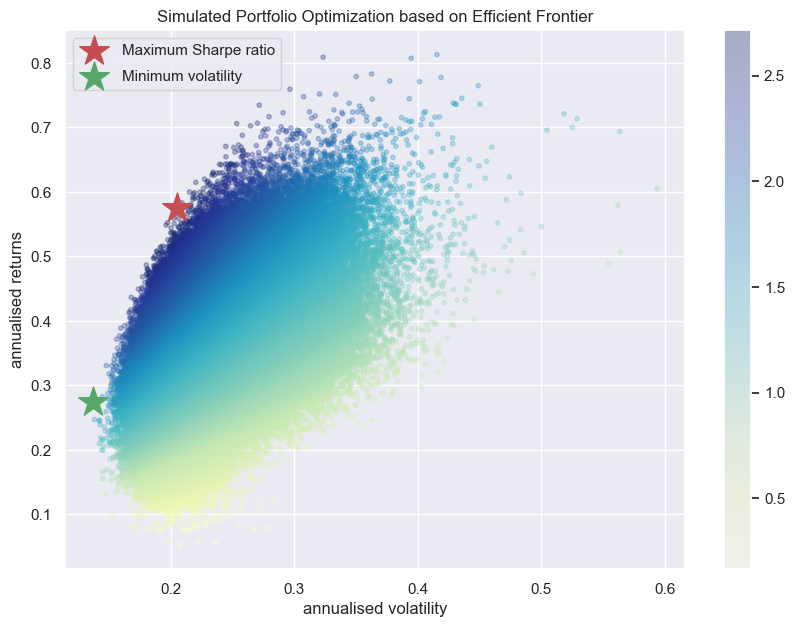

In [19]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

In [20]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [21]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

In [22]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [29]:
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=mean_returns.index,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=mean_returns.index,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 1, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.69
Annualised Volatility: 0.23


Ticker      BABA   UA   NVDA     KO   BAC   BA  INTC   GME   META   AAPL
allocation   0.0  0.0  28.49  17.57  7.14  0.0   0.0  2.59  26.34  17.86
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.15
Annualised Volatility: 0.11


Ticker      BABA   UA  NVDA     KO   BAC    BA  INTC  GME  META   AAPL
allocation  1.86  0.0  3.58  65.44  9.48  4.34   0.4  0.0  2.53  12.37


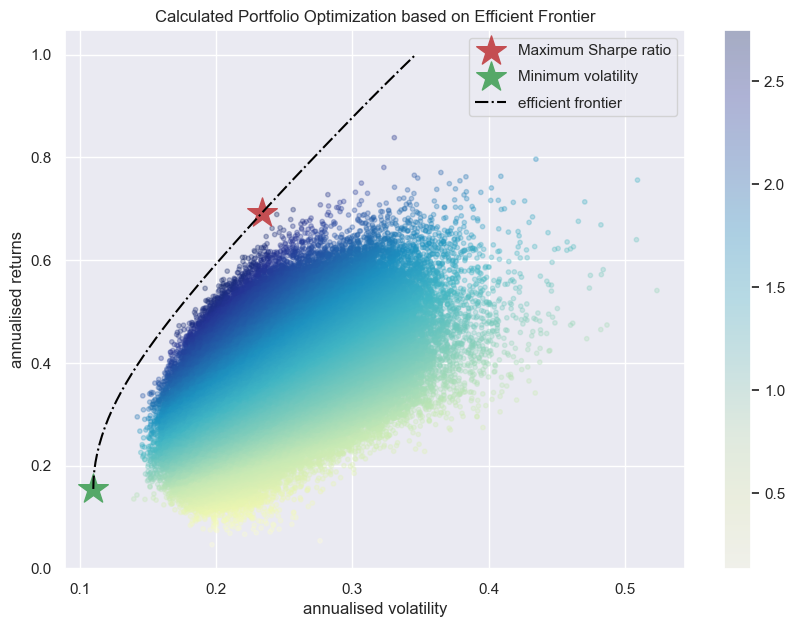

In [30]:
display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

In [31]:
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=mean_returns.index,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=mean_returns.index,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    print ("-"*80)
    print ("Individual Stock Returns and Volatility\n")
    for i, txt in enumerate(mean_returns.index):
        print (txt,":","annuaised return",round(an_rt[i],2),", annualised volatility:",round(an_vol[i],2))
    print ("-"*80)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(an_vol,an_rt,marker='o',s=200)

    for i, txt in enumerate(mean_returns.index):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 1.3, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    ax.set_title('Portfolio Optimization with Individual Stocks')
    ax.set_xlabel('annualised volatility')
    ax.set_ylabel('annualised returns')
    ax.legend(labelspacing=0.8)

c:\Users\dfdop\anaconda3\envs\quant\Lib\site-packages\numpy\_core\fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
C:\Users\dfdop\AppData\Local\Temp\ipykernel_12540\1946332043.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print (txt,":","annuaised return",round(an_rt[i],2),", annualised volatility:",round(an_vol[i],2))
C:\Users\dfdop\AppData\Local\Temp\ipykernel_12540\1946332043.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFra

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.69
Annualised Volatility: 0.23


Ticker      BABA   UA   NVDA     KO   BAC   BA  INTC   GME   META   AAPL
allocation   0.0  0.0  28.49  17.57  7.14  0.0   0.0  2.59  26.34  17.86
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.15
Annualised Volatility: 0.11


Ticker      BABA   UA  NVDA     KO   BAC    BA  INTC  GME  META   AAPL
allocation  1.86  0.0  3.58  65.44  9.48  4.34   0.4  0.0  2.53  12.37
--------------------------------------------------------------------------------
Individual Stock Returns and Volatility

BABA : annuaised return 0.05 , annualised volatility: 0.39
UA : annuaised return 0.01 , annualised volatility: 0.45
NVDA : annuaised return 1.25 , annualised volatility: 0.5
KO : annuaised return 0.03 , annualised volatility: 0.13
BAC :

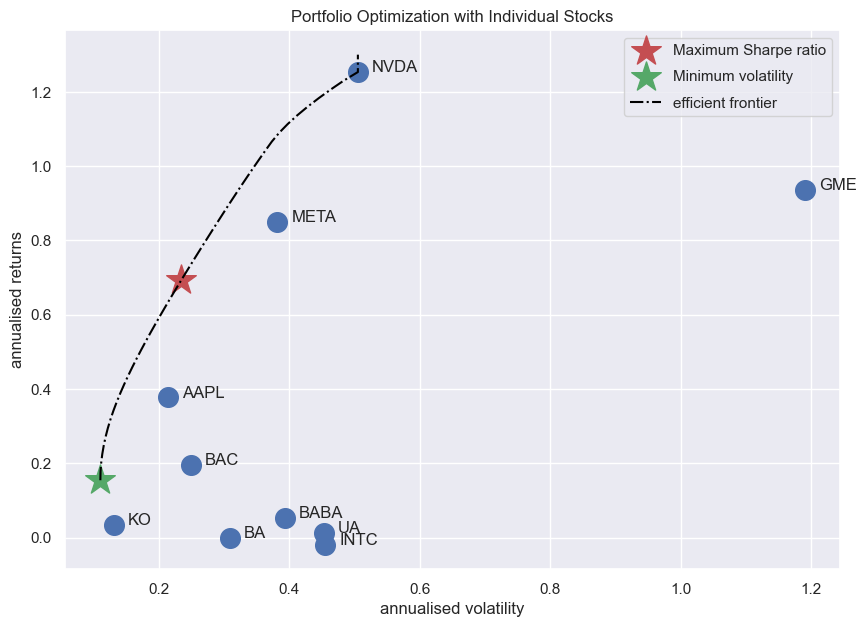

In [32]:
display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate)